# Load Data from MATLAB

### Import libraries

In [1062]:
%pip install pandas
import snntorch.spikeplot as splt
import scipy.io
import torch
from snntorch import spikegen
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1063]:
# DATA_FOLDER = "C:\Users\janso\Downloads\P1"
DATA_PATH = r"C:\\Users\\namit\\Downloads\\P1\\WS_P1_S9.mat"

mat_data = scipy.io.loadmat(DATA_PATH)
var = mat_data['ws'][0][0] # ws list basically

### Parse data into usable form

In [1064]:
identifier = None
participant_num = None
series = None
dataDict = None
for i, ele in enumerate(var):
    minivar = ele[0] # values in ws struct
    if i == 1:
        identifier = minivar
    elif i == 2:
        participant_num = minivar 
    elif i == 3:
        series = minivar
    else: # all of data
        dataDict = minivar

In [1065]:
# print(data)
# print('---------------------')
# print(type(data))
# print(len(data))
eeg_list = dataDict['eeg']
one_series = eeg_list[0]
print(f" electrodes: {len(one_series[0])} values: {len(one_series)}")

 electrodes: 32 values: 4570


time sampled values stored vertically, need to re-organize so can grab the values for one electrode at a time (rotate 90!)

In [1066]:
a = np.array(one_series)
print(a.shape)
transpose = np.transpose(a)
print(transpose.shape)

(4570, 32)
(32, 4570)


Text(0, 0.5, 'Voltage (mV)')

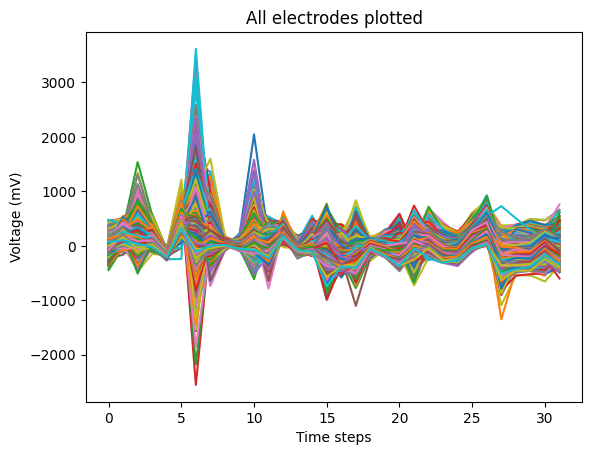

In [1067]:
data = torch.Tensor(transpose) # graph all spikes
plt.plot(data)
plt.title("All electrodes plotted")
plt.xlabel("Time steps")
plt.ylabel("Voltage (mV)")

Text(0, 0.5, 'Voltage (mV)')

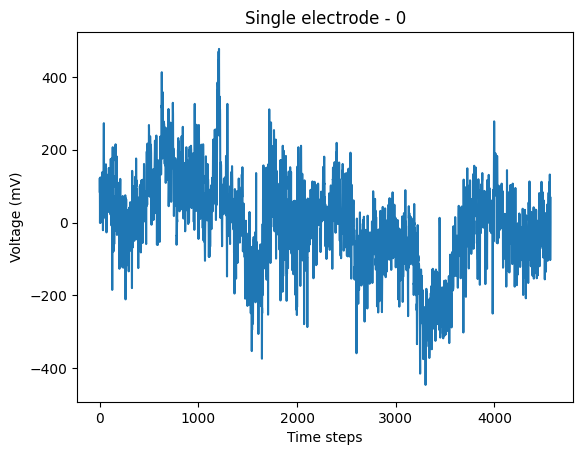

In [1068]:
one_spike = torch.Tensor(transpose[0]) # graph all spikes
plt.plot(one_spike)
plt.title("Single electrode - 0")
plt.xlabel("Time steps")
plt.ylabel("Voltage (mV)")

### Deciding threshold for One Electrode

In [1069]:
# related noise value and average
# consider varying noise paying attention to picking up/ staying still
# options for threshold:
# - consider st dev
# - break up data into time deltas
# - come back to later
# - neuron refraction
avg_threshold = np.median(transpose[0])
print(avg_threshold)

3.0


### Encode Data for One Electrode

In [1070]:
spike_data = spikegen.delta(one_spike, threshold=avg_threshold, off_spike=True)
print(spike_data)



tensor([ 1.,  1., -1.,  ...,  1.,  1.,  1.])


4570


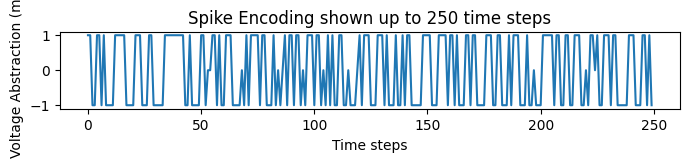

In [1071]:
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)
# splt.raster(spike_data, ax, c="black")
# plt.title("Input Neuron for first 100 time steps")
# plt.xlabel("Time step")
# plt.yticks([])
# plt.xlim(0, 100) # go up to transpose.shape[1]
# plt.show()
print(len(spike_data.numpy()))

time_step = 250
plt.title(f"Spike Encoding shown up to {time_step} time steps")
plt.xlabel("Time steps")
plt.ylabel("Voltage Abstraction (mV)")
plt.plot(spike_data.numpy()[:time_step])
plt.show()

In [1072]:
print("min :", np.min(spike_data.numpy()))
print("max :", np.max(spike_data.numpy()))

min : -1.0
max : 1.0


### Encode Data for all Electrodes in this Series

In [1073]:
all_encoded_series = []
for i,electrode in enumerate(transpose): # for each electrode in the transposed array
    avg_threshold = np.median(transpose[i])
    this_spike = torch.Tensor(transpose[i]) # graph all spikes
    # encoded + converted to numpy
    encoded_electrode_data = spikegen.delta(this_spike, threshold=avg_threshold, off_spike=True).numpy()
    all_encoded_series.append(encoded_electrode_data)

In [1074]:
print(len(all_encoded_series), len(all_encoded_series[0]))

32 4570


(32, 4570)
12 100
(12, 100)
(100, 12)


Text(0.5, 1.0, 'Spike Encoding shown up to 100 time steps')

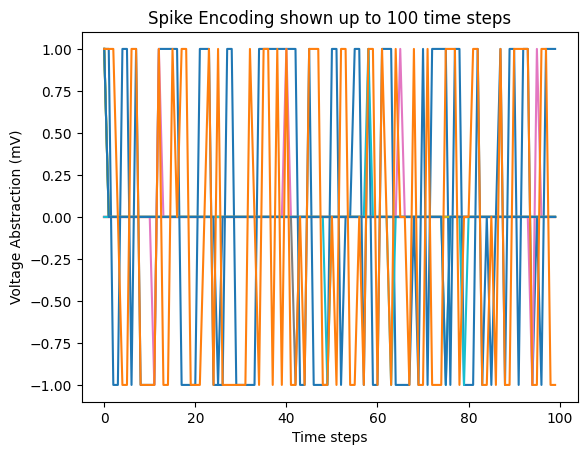

In [1075]:
num_electrodes = 12
time_step = 100
nparr = np.array(all_encoded_series)
print(nparr.shape)
arr = nparr[0:num_electrodes,0:time_step]
print(len(arr), len(arr[0]))


plot_this = torch.Tensor(arr)

a = plot_this.numpy()
print(a.shape)
transpose = np.transpose(a)
print(transpose.shape)

plt.xlabel("Time steps")
plt.ylabel("Voltage Abstraction (mV)")
plt.plot(transpose)
plt.title(f"Spike Encoding shown up to {time_step} time steps")

# for electrode_id in range(num_electrodes):
# fig = plt.figure(facecolor="w", figsize=(8,1))
# graph_num = 111
# ax = fig.add_subplot(graph_num)
# plt.title(f"Spike Encoding for electrode 1 shown up to {time_step} time steps")
# plt.xlabel("Time steps")
# plt.ylabel("Voltage Abstraction (mV)")
# plt.plot(arr[0])

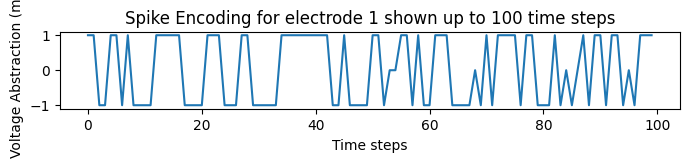

In [1076]:
fig = plt.figure(facecolor="w", figsize=(8,1))
graph_num = 111
ax = fig.add_subplot(graph_num)
plt.title(f"Spike Encoding for electrode 1 shown up to {time_step} time steps")
plt.xlabel("Time steps")
plt.ylabel("Voltage Abstraction (mV)")
plt.plot(arr[0])

In [1077]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [1078]:
all_encoded_series[0]

array([ 1.,  1., -1., ...,  1.,  1.,  1.], shape=(4570,), dtype=float32)

# Make Model

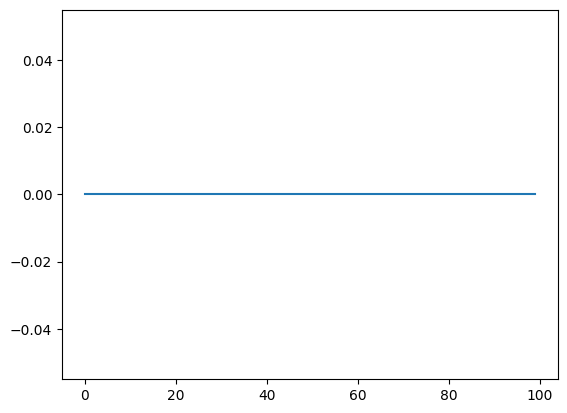

In [1079]:
# for i in arr:
#     print(i)

# R = 50M amps and C = 100pF (tao = 5ms)
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

num_steps = 100
U = 0
U_trace = [] # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U) # solve for next step of U

ax = fig.add_subplot(graph_num)
plt.plot(U_trace)


In [1080]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1,C=5e-3):
    tau_mem = R*C
    spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
    mem = mem + (time_step/tau_mem)*(-mem + cur*R)
    return mem, spk

# Lapicque: Without Stimulus

In [1081]:
time_step = 1e-3 # delta t
R = 5 # resistance 
C = 1e-3 # current 

lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

size = 1
mem = torch.ones(size) * .9            # U = 0.9 --> membrane potential initialized to 0.9 
# REPLACE BELOW W SPIKE ENCODED DATA
cur_in = torch.zeros(num_steps, 1)     # I=0 for all t (input is all 0, no input spikes) --> num_steps; 1 stands for dimensionality (will be 2D list with num_steps arrays with 0 as ele)
# OUR DATA
our_data = all_encoded_series[0]
cur_in = [] # converting to prior format
for i in our_data:
    cur_in.append([i])
cur_in = torch.from_numpy(np.array(cur_in))
# cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.1), 0)  # input current turns on at t=10
# cur_in = torch.cat((torch.zeros(10, 1), torch.ones(20, 1)*(0.1), torch.zeros(170, 1)), 0)  # input turns on at t=10, off at t=30

spk_out = torch.zeros(size)            # output spikes should be 0

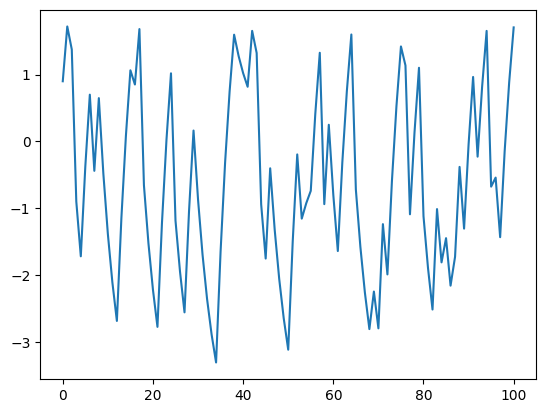

In [1082]:
mem_rec = [mem] # list to store recordings of membrane potentials

for step in range(num_steps): # for each step
  spk_out, mem = lif1(cur_in[step], mem) # get whether there was a spike & new membrane potential from lif1
  # Store recordings of membrane potential
  mem_rec.append(mem)
# convert the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)
# pre-defined plotting function
ax = fig.add_subplot(graph_num)

plt.plot(mem_rec)

remove artefacts (blinking, eye movement) ?

# Adding Fire/ Neuron Output Signal Functionality

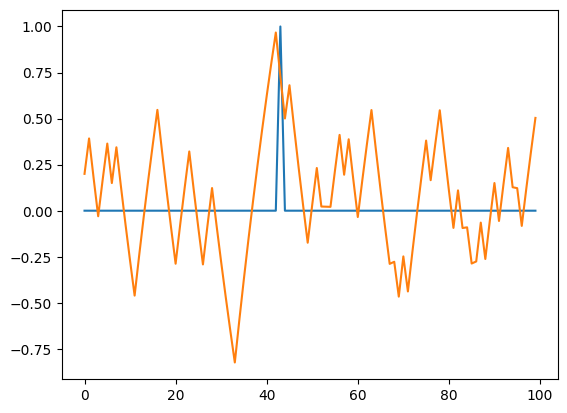

In [1083]:
our_data = all_encoded_series[0]
cur_in = [] # converting to prior format
for i in our_data:
    cur_in.append([i])
cur_in = torch.from_numpy(np.array(cur_in))

mem = torch.zeros(1)

# keep track
mem_rec = []
spk_rec = []

threshold = 0.8
# LFI
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step], threshold=threshold)
  mem_rec.append(mem)
  spk_rec.append(spk)

# torchify
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

ax = fig.add_subplot(graph_num)
plt.plot(spk_rec)
plt.plot(mem_rec)

In [1084]:
len(all_encoded_series)

32

# tutorial

In [1085]:
!pip install mne


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1086]:
!pip install edf

ERROR: Could not find a version that satisfies the requirement edf (from versions: none)
ERROR: No matching distribution found for edf

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Parsing New Dataset (with rest baseline)

In [1087]:
import mne 
import pandas as pd
def parse_data(filename):
    edf = mne.io.read_raw_edf(filename, preload=True, stim_channel=None)
    events, event_id = mne.events_from_annotations(edf)
    data, times = edf.get_data(return_times=True)
    epochs = mne.Epochs(edf,events, event_id=event_id, baseline=(0,0), tmin=0.0, tmax=0.0)
    x = epochs.get_data()
    y = epochs.events[:, 2]
    transposed_data = data.T

    # events is timestamp labelled with event (timestamps where it switches)
    # times are literally just times it was measured at
    # data is 64 sensors, each of which with 20000 values
    # data.shape
    t0 = []
    t1 = []
    t2 = []
    i=0
    o=0
    tw=0
    while i < len(epochs.events)-1: # for each event
        row = epochs.events[i]   # first data val
        row2 = epochs.events[i+1] # second data val
        timestamp1 = row[0] # first time
        timestamp2 = row2[0] # second time
        label = row[2] # label
        
        chunk = transposed_data[timestamp1:timestamp2]
        for snapshot in chunk:
            if label == 1 and o<1000:
                t0.append(snapshot)
                o+=1
            elif label == 2 and tw<1000:
                t1.append(snapshot)
                tw+=1
            #elif label == 3 and tw<1000:
                #t1.append(snapshot)
                #tw+=1
        i+=1    
        
    last = epochs.events[-1]
    timestamp = last[0]
    label = last[2]
    chunk = transposed_data[timestamp:]
    for snapshot in chunk:
        if label == 1 and o<1000:
            t0.append(snapshot)
            o+=1
        elif label == 2 and tw<1000:
            t1.append(snapshot)
            tw+=1
        #elif label == 3 and tw<1000:
            #t1.append(snapshot)
            tw+=1
    
    # print(len(t0), len(t0[0]))
    # print(len(t1), len(t1[0]))
    # print(len(t2), len(t2[0]))

    features = t0 + t1
    # print(len(features),len(features[0]))
    labels = [0]*len(t0) + [1]*len(t1)
    edf.plot(n_channels=64, duration=20, scalings='auto')
    return {'features': features, 'labels':labels}
# we want to split up whole timeseries into one vertical slice 

Extracting EDF parameters from c:\Users\namit\cmpm118\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1 original time points ...
0 bad epochs dropped


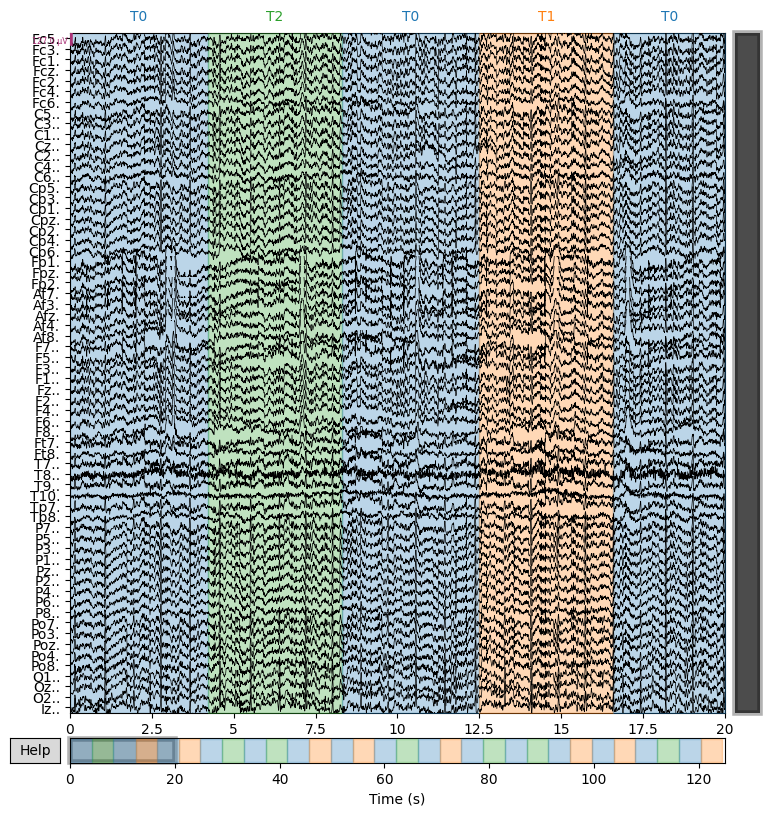

Extracting EDF parameters from c:\Users\namit\cmpm118\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1 original time points ...
0 bad epochs dropped


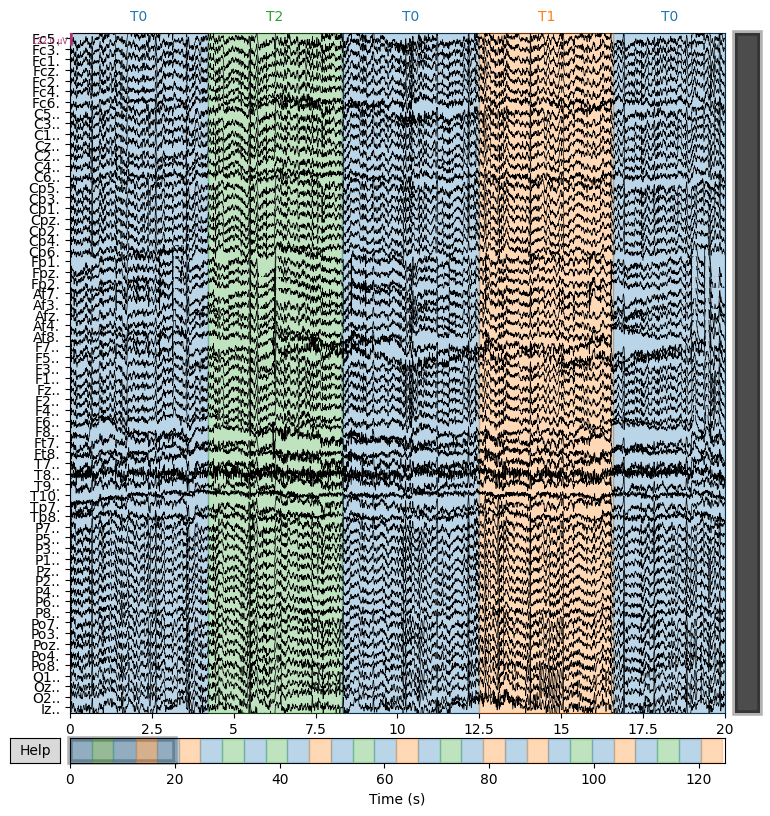

2000


In [1088]:
res = parse_data('S001R03.edf')
res2 = parse_data('S001R04.edf')
# res3 = parse_data('S001R07.edf')
# res4 = parse_data('S001R08.edf')
features = res['features']
labels = res['labels']
print(len(labels))

In [1089]:
class CustomDataset():
    def __init__(self, labels, features, transform=None):
        # with open(csv_file,"r") as f:
        #     self.data = pd.read_csv(f) # read the files
        # need to be in pandas format?
        col0 = np.array(labels).reshape(-1,1)
        cols = np.array(features)
        self.data = pd.DataFrame(np.hstack((col0, cols)))
        self.labels = labels # set the first line of the input data as the label (Originally 1 or 2, but we -1 here so they become 0 or 1)
        self.features = features # set the rest of the input data as the feature (FLUX over time)
        # what is below
        self.transform = transform # transformation (which is None) that will be applied to samples.
        # If you want to have a look at how does this dataset look like with pandas,
        # you can enable the line below.    
    def __len__(self): # function that gives back the size of the dataset (how many samples)
        return len(self.labels)
    def __getitem__(self, idx): # retrieves a data sample from the dataset
        label = self.labels[idx] # fetch label of sample
        feature = self.features[idx] # fetch features of sample

        if self.transform: # if there is a specified transformation, transform the data
            feature = self.transform(feature)

        sample = {'feature': feature, 'label': label}
        return sample

In [1090]:
train_dataset = CustomDataset(labels, features)
test_dataset = CustomDataset(res2['labels'], res2['features'])

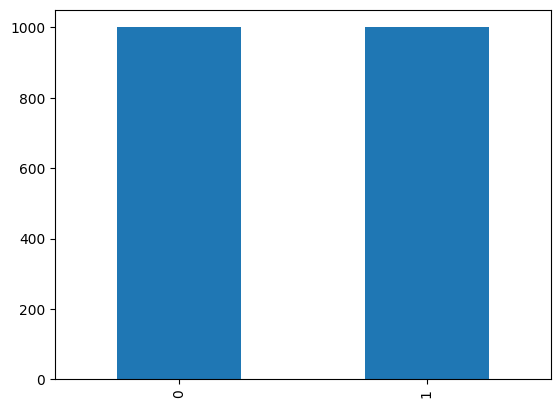

In [1091]:
label_counts= pd.Series(train_dataset.labels).value_counts().plot(kind='bar')

In [1092]:
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

Class distribution in the original training dataset: 0    1000
1    1000
Name: count, dtype: int64
Class distribution in the original testing dataset: 0    1000
1    1000
Name: count, dtype: int64


In [1093]:
# !pip install seaborn
# !pip install scikit-learn
# !pip install torch==2.6.0+cpu torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install plotly

In [1094]:
import snntorch as snn
from snntorch import surrogate

# pytorch
import torch._dynamo
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms

# SMOTE
# from collections import Counter

# plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# metric (AUC, ROC, sensitivity & specificity)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [1095]:
# %pip install imbalanced-learn
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='all') # initialize a smote, while sampling_strategy='all' means setting all the classes to the same size
# train_dataset.features, train_dataset.labels = smote.fit_resample(train_dataset.features, train_dataset.labels) # update the labels and features to the resampled data


In [1096]:
# print(train_dataset.data.head(4))

In [1097]:
batch_size = 64
spike_grad = surrogate.fast_sigmoid(slope=25) # ?????
beta = 0.5 # beta value initialization
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # create a dataloader for the trainset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # create a dataloader for the testset

In [1098]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Star #0 (Exoplanet)", "Star #1 (Exoplanet)",
                                                   "Star #3000 (No-Exoplanet)", "Star #3001 (No-Exoplanet)"))
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(0)['feature']),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(1)['feature']),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3)['feature']),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(23)['feature']),
    row=2, col=2
)
for i in range(1, 5):
    fig.update_xaxes(title_text="Time", row=(i-1)//2 + 1, col=(i-1)%2 + 1)
    fig.update_yaxes(title_text="Flux", row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.update_layout(height=600, width=800, title_text="Exoplanets Flux vs No-Exoplanet Flux",showlegend=False)
fig.show()

In [1099]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize layers (3 linear layers and 3 leaky layers)
        self.fc1 = nn.Linear(64, 128) # takes an input of 3197 and outputs 128
        #self.lif1 = snn.RLeaky(beta=beta, linear_features=64)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(64, 64) # takes an input of 64 and outputs 68
        #self.lif2 = snn.RLeaky(beta=beta, linear_features=32)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(32, 2) # takes in 32 inputs and outputs our two outputs (planet with/without an exoplanet)
        #self.lif3 = snn.RLeaky(beta=beta, linear_features=3)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        #spk1, mem1 = self.lif1.init_rleaky()
        #spk2, mem2 = self.lif2.init_rleaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        cur1 = F.max_pool1d(self.fc1(x), 2)
        #print(cur1.shape)
        #spk1, mem1 = self.lif1(cur1, spk1, mem1)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool1d(self.fc2(spk1), 2)
        #print(cur2.shape)
        #spk2, mem2 = self.lif2(cur2, spk2, mem2)
        spk2, mem2 = self.lif2(cur2, mem2)
        cur3 = self.fc3(spk2.view(batch_size, -1))
        #print(cur3.shape)
        # return cur3
        return cur3

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = Net()

In [1100]:
criterion = nn.CrossEntropyLoss()  # look up binarycross entropy if we have time
optimizer = optim.SGD(model.parameters(), lr=0.001) # stochastic gradient descent with a learning rate of 0.001

In [1101]:
results = pd.DataFrame(columns=['Epoch', 'Accuracy','Test Loss'])#['Epoch', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC-ROC', 'Test Loss'])
num_epochs = 100

In [1102]:
losses = []
for epoch in range(num_epochs): # iterate through num_epochs
    model.train() # forward pass
    for data in train_dataloader: # iterate through every data sample
        inputs, labels = data['feature'].float(), data['label']  # Float
        optimizer.zero_grad() # clear previously stored gradients
        outputs = model(inputs) #
        loss = criterion(outputs, labels) # calculates the difference (loss) between actual values and predictions
        loss.backward() # backward pass on the loss
        optimizer.step() # updates parameters
        losses.append(loss.detach().numpy())
        # print(loss)
    # Test Set, evaluate the model every epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_probs = []
        for data in test_dataloader:
            inputs, labels = data['feature'].float(), data['label']
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            print(predicted)
            softmax = torch.nn.Softmax(dim=1)
            probabilities = softmax(outputs)[:, 1]  # Assuming 1 represents the positive class
            all_probs.extend(probabilities.cpu().numpy())
        # output the accuracy (even though it is not very useful in this case)
        
        accuracy = 100 * correct / total
        # calculate teat loss
        # test_loss =
        # initialize a confusing matrix
        cm = confusion_matrix(all_labels, all_predicted)
        # grab the amount of true negatives and positives, and false negatives and positives.
        print(cm)
        tn, fp, fn, tp = cm.ravel()
        # calculate sensitivity
        sensitivity = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0.0
        # calculate specificity
        specificity = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0.0
        # calculate AUC-ROC
        auc_roc = 100 * roc_auc_score(all_labels, all_probs)
        print(
            f'Epoch [{epoch + 1}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader):.2f} '
            f'Test Accuracy: {accuracy:.2f}% Sensitivity: {sensitivity:.2f}% Specificity: {specificity:.2f}% AUC-ROC: {auc_roc:.4f}%'
        )
            # f'Test Accuracy: {accuracy:.2f}% Sensitivity: {sensitivity:.2f}% Specificity: {specificity:.2f}% AUC-ROC: {auc_roc:.4f}%'

        results = results._append({
            'Epoch': epoch + 1,
            'Accuracy': accuracy,
            'Test Loss': test_loss / len(test_dataloader),
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'AUC-ROC': auc_roc
        }, ignore_index=True)
            # 'Sensitivity': sensitivity,
            # 'Specificity': specificity,
            # 'AUC-ROC': auc_roc



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

C:\Users\namit\AppData\Local\Temp\ipykernel_42032\121685506.py:57: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

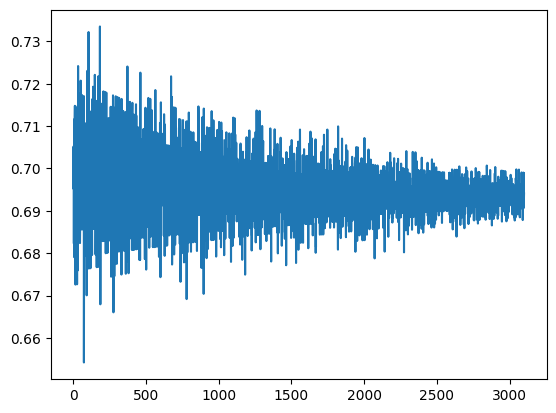

In [1103]:
plt.plot(losses)